# Keras MNIST
The idea is to create a neural network (MLP) with Keras to solve the MNIST classification. Then we can solve the exercise provided by the professor at lecture 4.


### Import and prepare dataset

In [13]:
import numpy as np
import tensorflow as tf
import keras as K
from keras.datasets import mnist

In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Let's print the shape of the data to see what are its dimentions.

In [15]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

X_train.shape: (60000, 28, 28)
X_test.shape: (10000, 28, 28)


As we can see on the shape of our data, we get a 3D tensor. Which means our dataset is a _"list of matrices"_ , each sample is a matrix of 28x28.

<img src="images/tensors.png" width="500"/>

MLP take vectors as inputs, so we need to reshape the samples into vector instead of matrices. Also Keras needs float32 inputs, so we need to change the data from uint8 (byte) to float32.

In [16]:
# Reshape the data
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(f"X_train.dtype: {X_train.dtype}")
print(f"X_train.dtype: {X_train.dtype}")

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)
X_train.dtype: float32
X_train.dtype: float32


### Keras Sequential Model

- **Sequential model**: A way to build neural networks in Keras layer by layer, in order.
- It creates a **Feedforward Neural Network (FFNN)**.
- It’s a **linear stack of layers**, meaning each layer has one input and one output.
- Perfect for models like **MLPs** (Multi-Layer Perceptrons).

*If your network flows from input to output in a straight line, use Sequential.*

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Dense is the type of neural network layer we use in MLPs where:
- Every neuron is connected to every neuron in the previous layer
- Also called a fully connected layer

In [18]:
np.random.seed(42)  # For reproducibility
tf.random.set_seed(42)

num_classes = len(np.unique(y_train))
print(f"Number of classes (labels): {num_classes}") # 10 one for each digit (0 to 9)

# Create a sequential model
model = Sequential([
    # First hidden layer. Input data with size 28*28 and output size 256
    #   256 means you set up this layer with 256 hidden neurons.
    #   Such a value is up to you, typically a hyper-parameter
    # input_shape must be specified just for the first hidden layer
    # in (28*28,) the comma indicates the dimension of the batches,
    #     unknowkn during the implementation
    Dense(256, input_shape=(28*28,), activation='sigmoid'),

    # Second hidden layer. Input data with size 256,
    #    which were same to output of the first hidden layer.
    #    output size 128, we set up 128 neurons  in this hidden layer.
    # No need to give input size here because keras gets it automatically.
    Dense(800, activation='sigmoid'),

    # Output layer. the number of output should be your number
    #    of classification
    # Softmax for multiclass classification
    Dense(num_classes, activation='softmax')
])

Number of classes (labels): 10


There's an alternative way to do the same, where we define the model and then use the `add()` method to add layers.

In [19]:
# model = Sequential()
# model.add(Dense(256, input_shape=(28*28,), activation='sigmoid'))
# model.add(Dense(128, activation='sigmoid'))
# model.add(Dense(num_classes, activation='softmax'))

The third alternative is to use the `tensorflow.keras.Model` class, along with a `tensorflow.keras.input` class.

This alternative is useful when we need to define models with **multiple inputs/multiple outputs**.

In [20]:
# input = tf.keras.Input(shape=(28*28,))
# hid1 = tf.keras.layers.Dense(256, activation='sigmoid')(input)
# hid2 = tf.keras.layers.Dense(128, activation='sigmoid')(hid1)
# output = tf.keras.layers.Dense(num_classes,activation='softmax')(hid2)
# model = tf.keras.Model(input, output)

Let's print out the model structure

In [21]:
model.summary()
# It should ouput the ouput shape and number of parameters for each layer.
# Notice that the None in the output shape tuples — like (None, 256) —
# means that the batch size is not fixed.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 800)            │       205,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,570 (1.58 MB)

 Trainable params: 414,570 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

#### Number of Parameters


- **First layer**:
    - Input size = 784+1(+1 for bias)
    - Output size = 256.
    - Parameters = 200960 = (784+1) * 256

- **Second layer**:
    - Input size = 256+1
    - Output size = 128.
    - Parameters = 32896 = (256+1) * 128

- **First layer**:
    - Input size = 128+1
    - Output size = 10.
    - Parameters = 1290 = (128+1) * 10

### Compile the model

Keras Model class provides a method, `compile()` to compile the model. It transform the model into a computational graph (possibly static), to get best execution performance.

This prepares the model to be trained with `fit()`.

In [22]:
model.compile(
    # optimizer = How the model updates weights (Stochastic Gradient Descent here)
    optimizer='SGD',
    # loss = How the model calculates the error
    loss='sparse_categorical_crossentropy',
    # metrics = How the model evaluates its performance
    metrics=['accuracy']
)

### Fit the model

In [23]:
batch_size = 64
epochs = 15

model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.1
)

Epoch 1/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4726 - loss: 1.9181 - val_accuracy: 0.8590 - val_loss: 0.8613
Epoch 2/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8366 - loss: 0.7851 - val_accuracy: 0.9058 - val_loss: 0.4676
Epoch 3/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8808 - loss: 0.4985 - val_accuracy: 0.9188 - val_loss: 0.3474
Epoch 4/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.3958 - val_accuracy: 0.9267 - val_loss: 0.2972
Epoch 5/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9082 - loss: 0.3429 - val_accuracy: 0.9318 - val_loss: 0.2629
Epoch 6/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9155 - loss: 0.3096 - val_accuracy: 0.9383 - val_loss: 0.2412
Epoch 7/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9213 - loss: 0.2827 - val_accuracy: 0.9392 - val_loss: 0.2253
Epoch 8/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9253 - loss: 0.2645 - val_accuracy: 0.

### Predict test data

Let's see what happens when we predict with our MLP in the test data.

Each prediction is a list with the probabilities for each digit (0 to 9). We then need to choose the maximum number to be the winner, we use `np.argmax()` that returns the index of the maximum element.

In [24]:
predictions = model.predict(X_test)
print(f"predictions.shape: {predictions.shape} \n")

print(f"Example of softmax prediction: \n {predictions[0]}")
category_predictions = np.argmax(predictions, axis=1)
print(f"\ncategory_predictions.shape: {category_predictions.shape}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
predictions.shape: (10000, 10) 

Example of softmax prediction: 
 [7.2415904e-05 1.4409322e-05 4.0726861e-04 2.2217340e-03 6.7918472e-06
 4.3300151e-05 1.6030624e-07 9.9655676e-01 1.0417885e-05 6.6663086e-04]

category_predictions.shape: (10000,)


Let's see an example of a prediction and check the actual element to see if the MLP is working correctly.

7


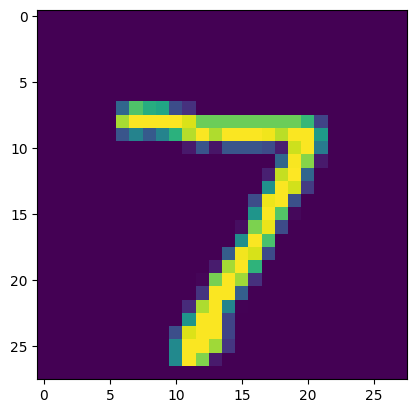

In [25]:
print(category_predictions[0])
# And let's check the image so we can confirm its actually a 7
from matplotlib import pyplot as plt
image = X_test[0].reshape(28,28)
plt.imshow(image)

It seems like its working correctly! Let's now compute the test accurracy.

In [26]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, category_predictions))

0.9464


### Exercise:

* Split the training data into train and validation sets (use for instance 80% and 20%)
* Operate a model selection for the following hyper-parameters
    1. **Number of layers** (for instance try 1 or 2 hidden layers)
    2. **Number of hidden units** fixed the numer of layers (128 or 256)
    3. **Batch size** (try 32 or 128). What main differences do you observe?
* Evaluate if the number of epochs is large enough

#### What to do:
1. Split original training data into train and validation sets again.
2. Fix a set of possible configurations for all hyper-parameters.
3. Loop over any possible configuration
    * For any config, train a model on training data.
    * Evaluate the performance on validation data
    * Pick the configuration having the highest accuracy on validation data
4. Merge again train and validation data to get a unique training set
5. Train the final model with the chosen configuration and evaluate it on the test set

### Solution

In [27]:
from sklearn.model_selection import train_test_split

# 1) Split the Training dataset into Training and Validation again
train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train,
                                                            test_size=0.2)

print(f"train_data.shape:{train_data.shape},  \nval_data.shape:{val_data.shape}")
print(f"train_labels.shape:{train_labels.shape}, \nval_labels.shape:{val_labels.shape}")

train_data.shape:(48000, 784),  
val_data.shape:(12000, 784)
train_labels.shape:(48000,), 
val_labels.shape:(12000,)


In [28]:
# 2) Fix all the possible configurations for all hyper-parameters
from itertools import product

# Define the possible values for each hyperparameter
num_layers = [1, 2]
hidden_units = [128, 256]
batch_size = [32, 128]

# Create all combinations of configurations
configs = list(product(num_layers, hidden_units, batch_size))

# Format them as dictionaries
config_dicts = [
    {"num_layers": nl, "hidden_units": hu, "batch_size": bs}
    for nl, hu, bs in configs
]

In [29]:
# 3) Let's now iterate over all the possible configs and train a model for each one
best_config = (None, 0) # (best_config, accurracy)

for config in config_dicts:
    # Create the model for each configuration
    model = Sequential()
    for i in range(config["num_layers"]):
        model.add(Dense(config["hidden_units"], activation='sigmoid'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer='SGD',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        batch_size = config["batch_size"],
        verbose=0
    )
    
    # Evaluate the model
    predictions = model.predict(val_data)
    category_predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(val_labels, category_predictions)
    
    print(f"Config: {config}\nAccuracy: {accuracy}\n")

    # Update the best configuration
    if accuracy > best_config[1]:
        best_config = (config, accuracy)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
Config: {'num_layers': 1, 'hidden_units': 128, 'batch_size': 32}
Accuracy: 0.9405833333333333

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
Config: {'num_layers': 1, 'hidden_units': 128, 'batch_size': 128}
Accuracy: 0.93325

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
Config: {'num_layers': 1, 'hidden_units': 256, 'batch_size': 32}
Accuracy: 0.9525

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
Config: {'num_layers': 1, 'hidden_units': 256, 'batch_size': 128}
Accuracy: 0.9426666666666667

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
Config: {'num_layers': 2, 'hidden_units': 128, 'batch_size': 32}
Accuracy: 0.9390833333333334

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
Config: {'num_layers': 2, 'hidden_units': 128, 'batch_size': 128}
Accuracy: 0.9164166666666667

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
Config: {'num_layers': 2, 'hidden_units': 256, 'batch_size': 32}
Accuracy: 0.9493333333333334

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Config: {'n

In [30]:
# 4) Merge the training and validation datasets to get a unique training dataset.
X_train = np.concatenate([train_data, val_data])
y_train = np.concatenate([train_labels, val_labels])

In [31]:
# 5) Train the model with the best configuration using the unique training dataset.
model = Sequential()
for i in range(best_config[0]["num_layers"]):
    model.add(Dense(best_config[0]["hidden_units"], activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    X_train,
    y_train,
    epochs=20, # After 20 epochs, the accuracy starts decreasing
    batch_size = best_config[0]["batch_size"]
)

# Evaluate the model with the test dataset
predictions = model.predict(X_test)
category_predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, category_predictions)
print(f"Accuracy of the best configuration: {accuracy}")
print(f"Same as above but only trained on the sub-trianing set: {best_config[1]}")

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 749us/step - accuracy: 0.7682 - loss: 0.8377
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.9095 - loss: 0.3321
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.9229 - loss: 0.2757
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.9325 - loss: 0.2432
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.9380 - loss: 0.2202
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step - accuracy: 0.9427 - loss: 0.2067
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9448 - loss: 0.1954
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.9476 - loss: 0.1831
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.9499 - loss: 0.1756
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9524 - loss: 0.1674
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.9535 - loss: 0.1641
Epoch 12